In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


Dataset approval and preprocessing

In [61]:
data = pd.read_csv('credit_card_approval.csv')

# Remove the missing values
data = data.dropna()


# Drop the ID 
data.drop('ID', axis=1, inplace=True)
# print(data.head())

data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
data['BEGIN_MONTHS'] = abs(data['BEGIN_MONTHS'])




# Split the data into features and target
features = data.drop('TARGET', axis=1)
target = data['TARGET']




# print(data.head())


Exploratory Data Analysis

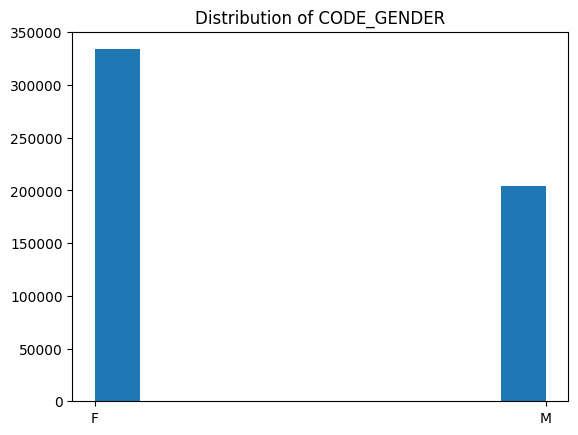

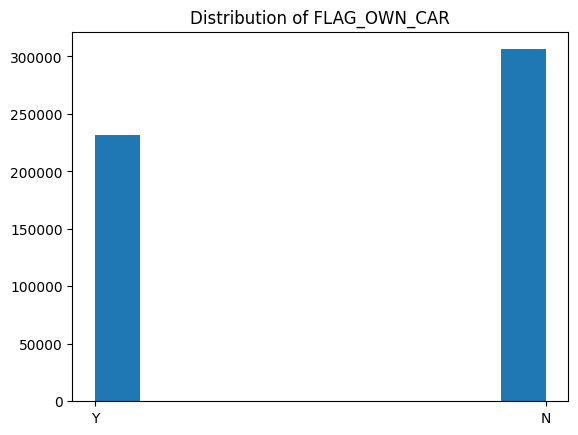

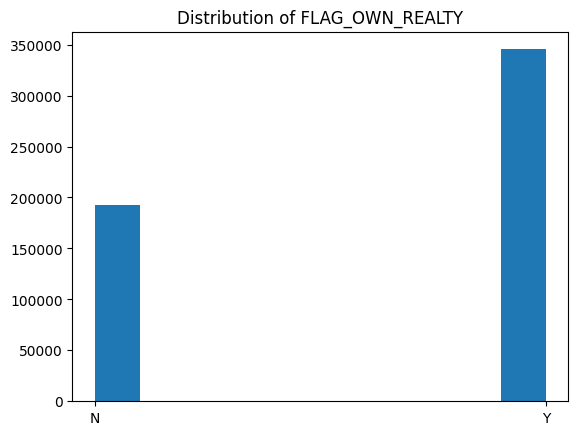

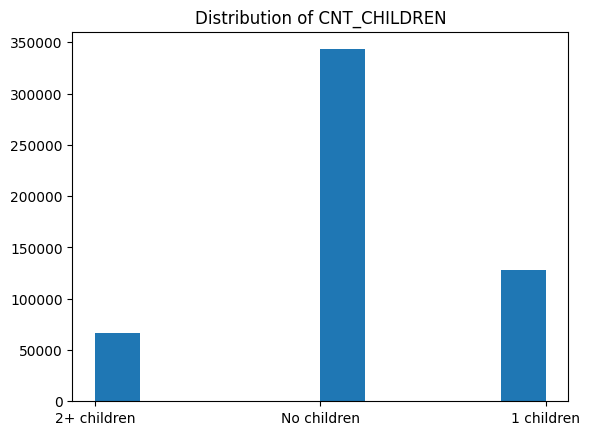

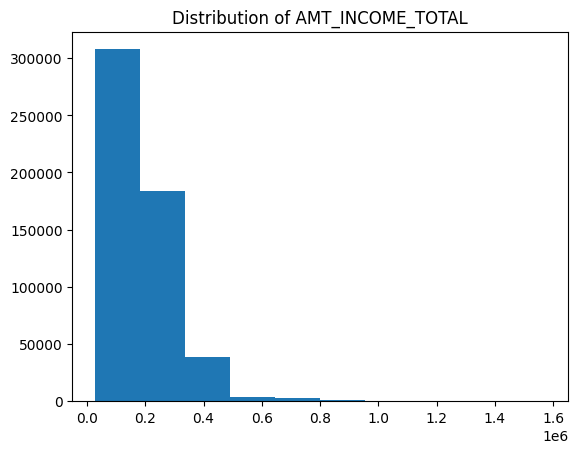

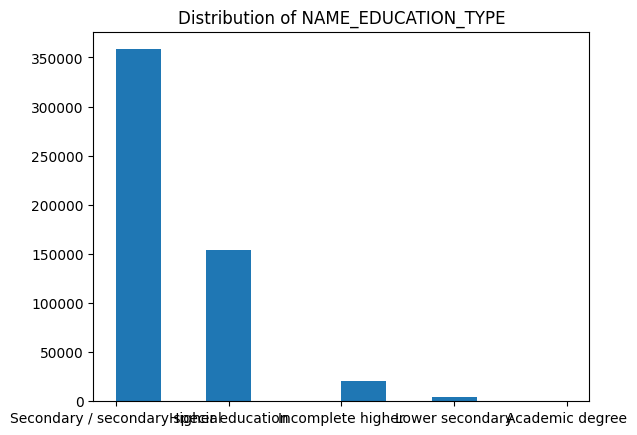

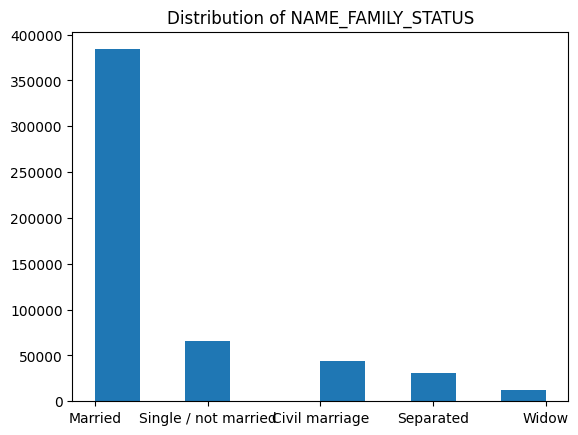

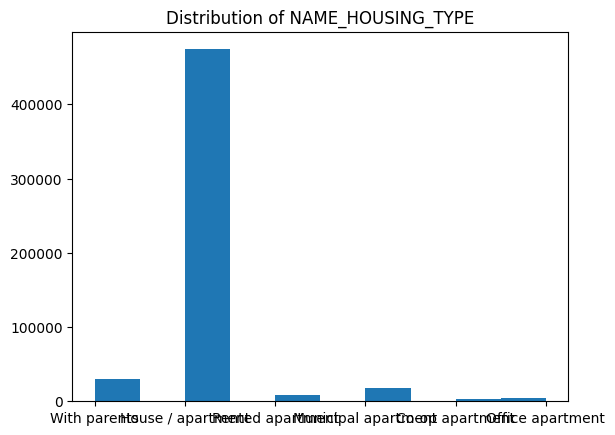

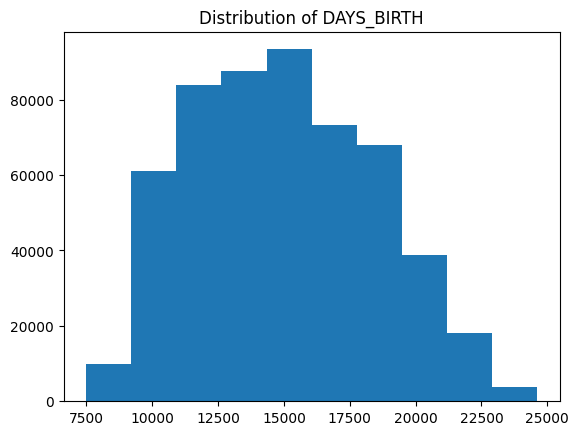

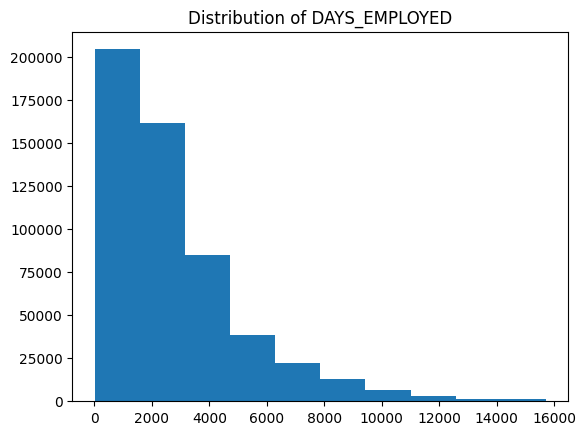

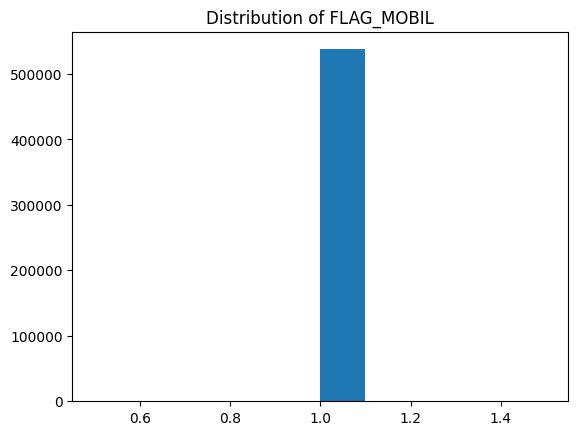

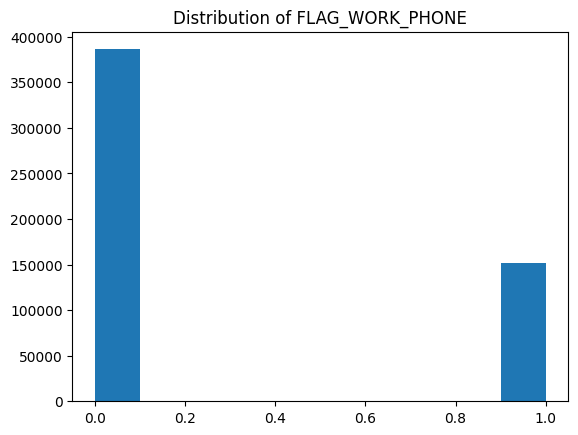

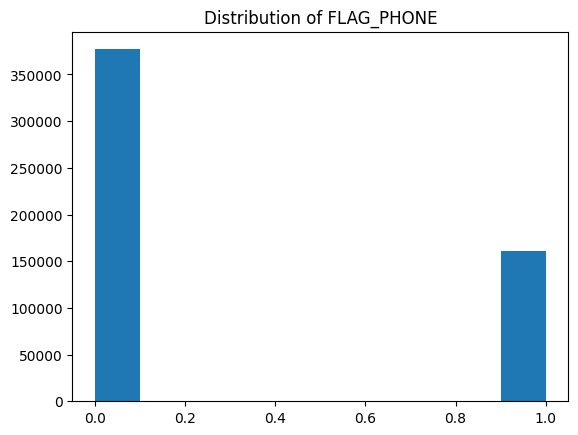

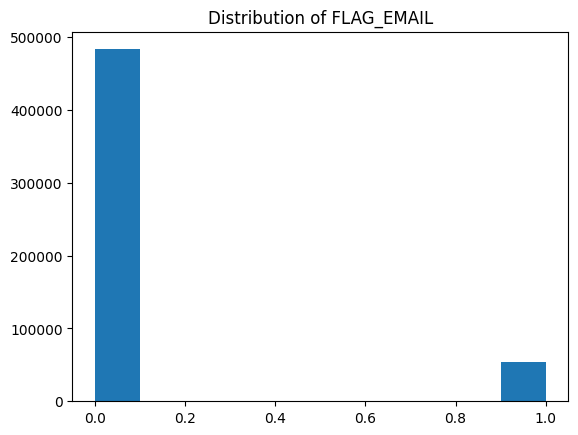

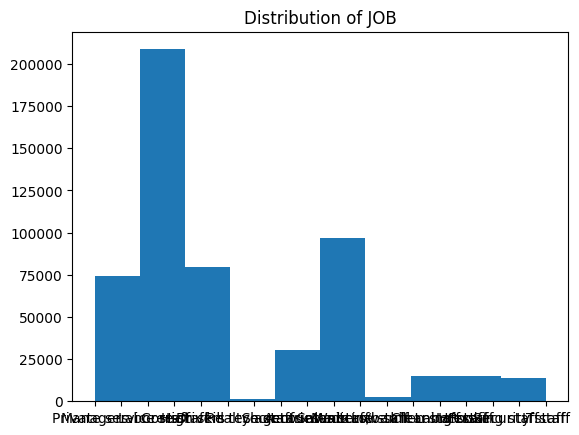

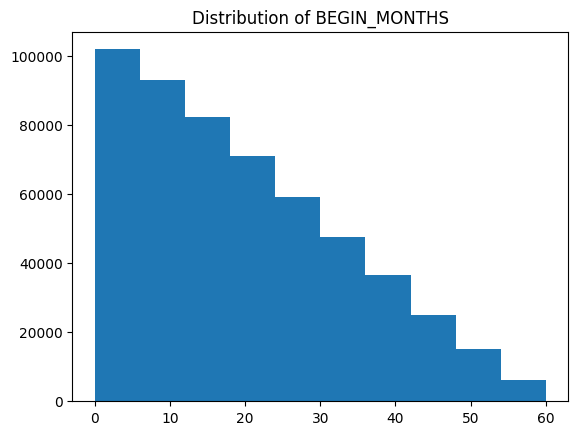

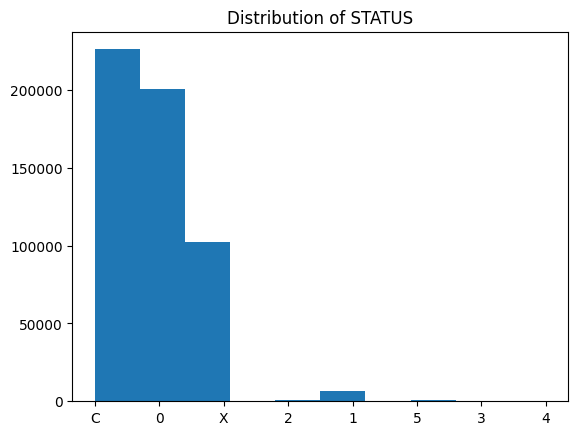

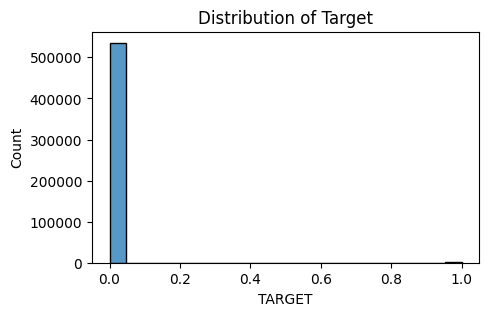

In [62]:
# Visualize the distribution of the features and target
for column in features.columns:
    plt.hist(features[column])
    plt.title(f'Distribution of {column}')
    plt.show()
plt.figure(figsize=(5, 3))
sns.histplot(target)
plt.title('Distribution of Target')
plt.show()



In [63]:
#  Encode the gender, flag_own_car columns and flag_own_realty, F as 1, M as 0, and Y as 1, N as 0.
data['CODE_GENDER'] = data['CODE_GENDER'].map({'F': 1, 'M': 0})
data['FLAG_OWN_CAR'] = data['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
data['FLAG_OWN_REALTY'] = data['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})


# Preprocess the children column, replace "2+ Children" with 2, "1 Child" with 1, and "No Children" with 0.
def process_children(x):
    if 'No children' in x:
        return 0
    elif '1 children' in x:
        return 1
    elif '2+ children' in x:
        return 2  
    
    else:
        return None 
data['CNT_CHILDREN'] = data['CNT_CHILDREN'].apply(process_children)

# One-hot encode the columns NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, and JOB.
data = pd.get_dummies(data, columns=['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'JOB'])

# Defite status
status_mapping = {
    '0': 1,   # 1-29 days past due
    '1': 2,   # 30-59 days past due
    '2': 3,   # 60-89 days overdue
    '3': 4,   # 90-119 days overdue
    '4': 5,   # 120-149 days overdue
    '5': 6,   # Overdue or bad debts, write-offs for more than 150 days
    'C': 0,   # paid off that month
    'X': -1   # No loan for the month
}

data['STATUS'] = data['STATUS'].map(status_mapping)

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
print(features.head())







  CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY CNT_CHILDREN  AMT_INCOME_TOTAL  \
0           F            Y               N  2+ children          270000.0   
1           F            N               N  No children           81000.0   
2           M            Y               Y  No children          270000.0   
3           F            Y               Y   1 children          112500.0   
4           M            Y               Y  2+ children          139500.0   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special               Married       With parents   
1  Secondary / secondary special  Single / not married  House / apartment   
2               Higher education               Married  House / apartment   
3  Secondary / secondary special               Married  House / apartment   
4  Secondary / secondary special               Married  House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
0